### XGboost for Calibration

https://github.com/marugari/xgboost/tree/calibration

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
from xgboost.sklearn import XGBCalibrator

http://scikit-learn.org/stable/modules/calibration.html

https://github.com/scikit-learn/scikit-learn/tree/master/examples/calibration

In [3]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

np.random.seed(2018)

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = IsotonicRegression(out_of_bounds='clip')
    # Calibrated with XGBoost calibration
    xgbcal = XGBCalibrator(n_estimators=300)
    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')
    
    est.fit(X_train, y_train)
    lr.fit(X_train, y_train)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, cal, name in [(lr, None, 'Logistic'),
                           (est, None, name),
                           (est, isotonic, name + ' + Isotonic'),
                           (est, xgbcal, name + ' + XGBoost')]:
        if cal is not None:
            p_valid = clf.predict_proba(X_valid)[:, 1]
            cal.fit(p_valid, y_valid)
            p_test = clf.predict_proba(X_test)[:, 1]
            if hasattr(cal, "predict_proba"):
                prob_pos = cal.predict_proba(p_test)[:, 1]
            else:
                prob_pos = cal.predict(p_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]
        
        # logloss
        clf_score = log_loss(y_test, prob_pos)
        
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

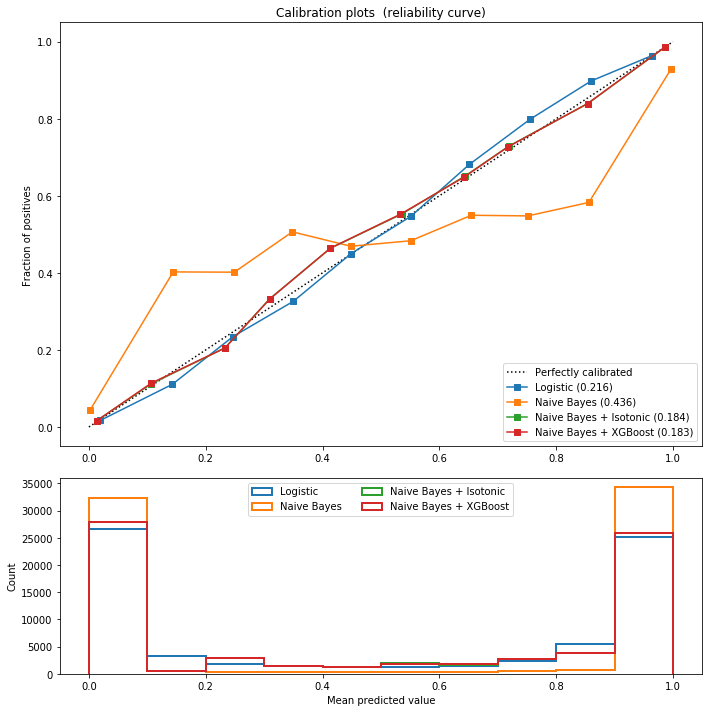

In [4]:
# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)
plt.show()